## Maaslin 2 Analysis of GO Terms for COVIRT19

 Lets install some R packages that we are gonna need to run this analysis

#if(!requireNamespace("BiocManager", quietly = TRUE))
#install.packages("BiocManager")

In [2]:
#if(!requireNamespace("BiocManager", quietly = TRUE)) 
#    install.packages("BiocManager")

In [3]:
#BiocManager::install("Maaslin2")
#BiocManager::install('DESeq2')
#BiocManager::install('phyloseq')
#BiocManager::install('microbiome')
#BiocManager::install("DirichletMultinomial")

In [4]:
#install.packages("remotes")
#remotes::install_github("mikemc/speedyseq")

Now lets load our libraries and set out environment

In [5]:
library(tidyverse)
library(phyloseq)
library(microbiome)
library(DESeq2)
library(Maaslin2)
library(parallel)
library(DirichletMultinomial)
library(pheatmap)
library(ggpubr)
library(viridis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEv

In [6]:
getwd()
setwd('/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/')

[1] "/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2"

In [7]:
raw<-as_tibble(read.table("Combined_BALF_GO_Terms_parent_propagated.tsv", sep = "\t", row.names = NULL, header = T, quote = "", comment.char = ""))

A tibble: 47,233 x 2,020     # good so far now
do a little regex and fix some stuff

In [8]:
colnames(raw)<-gsub("NA_tax","unclass", colnames(raw))%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")

Transform the raw table by type of count (euk, term, bac, arc)

In [9]:
df<-raw %>%
  select(GO_term,namespace,depth,name,ends_with("_counts"))%>%
  pivot_longer(cols = -c(GO_term,namespace,depth,name),
               names_to =  c("sample","type","abund"),#c("Total", "Archaea","Bacteria","Eukarya", "Viridae", "Unclassified"),
               names_pattern = "(.*)_(.*)_(.*)")%>%
  select(-abund)%>%
  filter(value>1)%>%
  pivot_wider(names_from = sample, values_from=value, values_fill=0)
#SIDE NOTE:There are multiple processes and values for a single sample so you cant convert the sample to columns

Make individual tibbles for biological processes and molecular fxn

In [10]:
bio<-filter(df, namespace=="biological_process")
mol<-filter(df, namespace=="molecular_function")

make individual tibbles for each type (bac, euk, term, arc, vir, etc)

In [11]:
bio_bac<-bio%>%filter(type=="bac")%>%select(-type)
bio_term<-bio%>%filter(type=="term")%>%select(-type)
mol_bac<-mol%>%filter(type=="bac")%>%select(-type)
mol_term<-mol%>%filter(type=="term")%>%select(-type)

subselect tibbles for only the counts and go terminology

In [12]:
bio_bac_counts<-bio_bac%>%select(-c(namespace,depth,name))
bio_bac_tax<-bio_bac%>%select(GO_term,namespace,depth,name)
mol_bac_counts<-mol_bac%>%select(-c(namespace,depth,name))
mol_bac_tax<-mol_bac%>%select(GO_term,namespace,depth,name)

convert them to dataframes for downstream import to phylsoeq

In [13]:
bio_bac_counts<-data.frame(bio_bac_counts, row.names=1)
bio_bac_tax<-data.frame(bio_bac_tax, row.names=1)
mol_bac_counts<-data.frame(mol_bac_counts, row.names=1)
mol_bac_tax<-data.frame(mol_bac_tax, row.names=1)

convert the dataframes into phyloseq formats

In [14]:
bio_bac_counts_phy <- otu_table(bio_bac_counts, taxa_are_rows=TRUE)
bio_bac_tax_phy <- tax_table(as.matrix(bio_bac_tax), errorIfNULL=TRUE)
mol_bac_counts_phy<-otu_table(mol_bac_counts, taxa_are_rows = T)
mol_bac_tax_phy<-tax_table(as.matrix(mol_bac_tax), errorIfNULL = T)

import your metadata

In [15]:
bio_bac_sam<-as.data.frame(read.table("Combined_BALF_GO_Terms_metadata.txt",header = T, sep = "\t",row.names = 1))

a little regex to fix the stupid filename

In [16]:
rownames(bio_bac_sam)<-rownames(bio_bac_sam)%>%str_replace_all("NC1_SRR7796663", "NC1.SRR7796663")
bio_bac_sam$accession<-rownames(bio_bac_sam)

making physeq object

In [17]:
bio_bac_pseq <- phyloseq(bio_bac_counts_phy, bio_bac_tax_phy, sample_data(bio_bac_sam))
mol_bac_pseq<-phyloseq(mol_bac_counts_phy,mol_bac_tax_phy, sample_data(bio_bac_sam))
bac_pseq<-merge_phyloseq(bio_bac_pseq,mol_bac_pseq)
bac_pseq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 167 samples ]
sample_data() Sample Data:       [ 167 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

filter out the negative control and unknown samples

In [18]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg# [ 13846 taxa and 162 samples ]:
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

Lets change the names of the Go Terms so we can understand the description as well as the tag

This code was causing mismatches with name and GO TAG and has since been resolved 19 NOV 2020

In [19]:
#names<-paste(taxa_names(bac_pseq_no_neg),get_taxa_unique(bac_pseq_no_neg,taxonomic.rank = "name" ),sep = "-")
#taxa_names(bac_pseq_no_neg)<-names

NEW and improved code

In [20]:
tax<-data.frame(tax_table(bac_pseq_no_neg))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_no_neg)<-names

[1] 13846

# DESeq2 VST transformation

In [21]:
sample_info_tab<-sample_data(bac_pseq_no_neg)
sample_info_tab_phy <- sample_data(sample_info_tab)
deseq_counts<-phyloseq_to_deseq2(physeq = bac_pseq_no_neg,design = ~ 1) 
deseq_counts_vst <- estimateSizeFactors(deseq_counts, type = "poscounts")
vst_trans_count_tab <- assay(deseq_counts_vst)

converting counts to integer mode



#YAAAAAAAAAAAAAAAASSSSSSSSSSSSS THANK YOU LIMMMA

IT FIXED THE BATCH EFFECT!

Dont worry about the limma batch effect correction step, I think I found a better way by including it in the multivariate model 

In [22]:
#vst_trans_count_tab2 <- limma::removeBatchEffect(vst_trans_count_tab, sample_info_tab$publication)

In [23]:
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows=T)
vst_tax_phy <- tax_table(bac_pseq_no_neg)
vst_physeq <- phyloseq(vst_count_phy, vst_tax_phy,sample_data(bac_pseq_no_neg))
vst_physeq_comp<-microbiome::transform(x = vst_physeq,transform = "compositional")

# MaAsLIN2

In [24]:
#dir.create("R_Maaslin2") # Create a new directory
setwd("/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2/") # Change the current working directory 
getwd() #check if directory has been successfully changed

[1] "/home/jovyan/work/Jochum_3/jupyter_lab/GO_term_analysis/R_Maaslin2"

In [25]:
df_input_data2<-data.frame(t(otu_table(vst_physeq_comp)))
df_input_metadata2<-data.frame(sample_data(vst_physeq_comp))

## ok so here are the parameters you want to manipulate:
min abundance= the min rel abund hits (1%) #filters out XXXX GO_terms \
min prevalence = Min samples required with min abundance for a feature not to be filtered (0.1=10%=14.1000 samples) \
max_significance = the maximinum p adjusted value to be significant \

This will filter out 13770 GO TERMS \

#_normalization = CLR transformation_ \
##### CORRECTION dont normalize here, just use the VST transformed counts
correction = the mutliple test correction method to be done (BH=Benjamini-Hochberg)

[1] "Warning: Deleting existing log file: .//maaslin2.log"
2020-11-20 00:08:47 INFO::Writing function arguments to log file
2020-11-20 00:08:47 INFO::Verifying options selected are valid
2020-11-20 00:08:47 INFO::Determining format of input files
2020-11-20 00:08:47 INFO::Input format is data samples as rows and metadata samples as rows
2020-11-20 00:08:47 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-11-20 00:08:47 INFO::Formula for fixed effects: expr ~  case
2020-11-20 00:08:47 INFO::Filter data based on min abundance and min prevalence
2020-11-20 00:08:47 INFO::Total samples in data: 141
2020-11-20 00:08:47 INFO::Min samples required with min abundance for a feature not to be filtered: 1.410000
2020-11-20 00:08:47 INFO::Total filtered features: 13730
2020-11-20 00:08:47 INFO::Filtered feature names from abundance and prevalence filtering: GO.0045212.obsolete.neurotransmitter.receptor.biosynthetic.process, GO.0001319.obsolete.inheritance.of.oxid

feature,metadata,value,coef,stderr,pval,name,qval,N,N.not.zero
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
GO.0034660.ncRNA.metabolic.process,case,Control_Healthy,0.003981729,0.0006363000,6.141635e-09,caseControl_Healthy,9.207658e-07,141,133
GO.0016740.transferase.activity,case,Control_Sick,0.009075342,0.0014692305,1.000640e-08,caseControl_Sick,9.207658e-07,141,135
GO.0140098.catalytic.activity..acting.on.RNA,case,Control_Healthy,0.002885018,0.0004690039,1.190645e-08,caseControl_Healthy,9.207658e-07,141,134
GO.0043170.macromolecule.metabolic.process,case,Control_Healthy,0.005589451,0.0009112669,5.975284e-08,caseControl_Healthy,3.465665e-06,141,136
GO.0016070.RNA.metabolic.process,case,Control_Healthy,0.004123315,0.0007253395,8.995331e-08,caseControl_Healthy,4.173833e-06,141,135
GO.0019538.protein.metabolic.process,case,Control_Healthy,0.001399883,0.0002644551,6.075878e-07,caseControl_Healthy,2.349339e-05,141,134
GO.0016740.transferase.activity,case,Control_Healthy,0.007359575,0.0015327899,4.688498e-06,caseControl_Healthy,1.359664e-04,141,135
GO.0043168.anion.binding,case,Control_Healthy,0.001858915,0.0003835658,4.147677e-06,caseControl_Healthy,1.359664e-04,141,137
GO.1901362.organic.cyclic.compound.biosynthetic.process,case,Control_Healthy,-0.002910851,0.0006344737,1.155774e-05,caseControl_Healthy,2.437632e-04,141,138


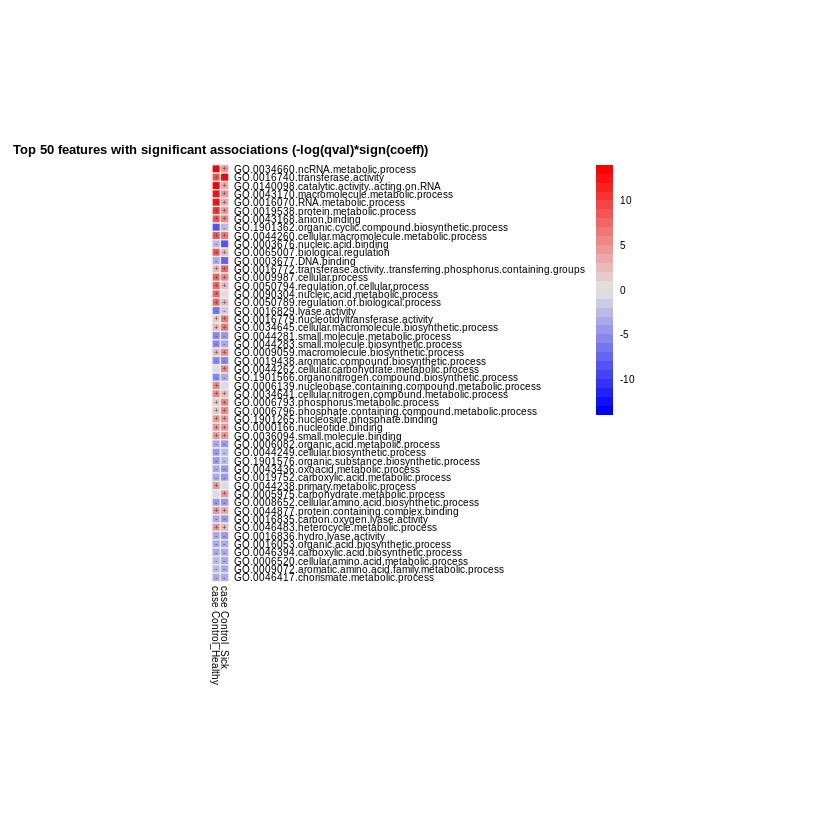

In [26]:
Maaslin2(
  input_data = df_input_data2,
  input_metadata = df_input_metadata2,
  output="./",
  min_abundance = 0.01,
  min_prevalence = 0.01,
  normalization = "NONE",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.25,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n = 100,
  reference=c("case,COVID19"))

OK OK OK OK NEXT I HAVE TO DO THIS ON THE COVID19 CASES ONLY (OR MAYBE ALL THE CASES AND JUST DELINEATE COVID19 BY OUTCOME) AND DO IT BY OUTCOME

## DMM modeling using the MaAslin2 derived terms

Ok, lets import the MaAsLin2 derived significant terms

In [27]:
sig<-read.table("Significant_Go_terms_for_Beth_Maaslin2.txt",header = T,sep = "\t")
head(sig)

,GO_Tag,name,metadata,value.as.compared.to.COVID19.,coef,stderr,N,N.not.0,pval,qval,phyloseq_taxid,X
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<lgl>
1,GO:0034660,ncRNA metabolic process,case,Control_Healthy,0.003981729,0.000636300,141,133,6.14e-09,9.21e-07,GO.0034660.ncRNA.metabolic.process,NA
2,GO:0016740,transferase activity,case,Control_Sick,0.009075342,0.001469230,141,135,1.00e-08,9.21e-07,GO.0016740.transferase.activity,NA
3,GO:0140098,catalytic activity acting on RNA,case,Control_Healthy,0.002885018,0.000469004,141,134,1.19e-08,9.21e-07,GO.0140098.catalytic.activity..acting.on.RNA,NA
4,GO:0043170,macromolecule metabolic process,case,Control_Healthy,0.005589451,0.000911267,141,136,5.98e-08,3.47e-06,GO.0043170.macromolecule.metabolic.process,NA
5,GO:0016070,RNA metabolic process,case,Control_Healthy,0.004123315,0.000725339,141,135,9.00e-08,4.17e-06,GO.0016070.RNA.metabolic.process,NA
6,GO:0019538,protein metabolic process,case,Control_Healthy,0.001399883,0.000264455,141,134,6.08e-07,2.35e-05,GO.0019538.protein.metabolic.process,NA


## DMM Preprocessing /filtering

Ok lets filter out the GO_tag mataches from our phyloseq object

In [28]:
Terms<-sig$GO_Tag

In [29]:
bac_pseq_no_neg<-subset_samples(bac_pseq, sample_type!="neg_control")
bac_pseq_no_neg<-subset_samples(bac_pseq_no_neg, sample_type!="Unknown")
bac_pseq_no_neg# [ 13846 taxa and 141 samples ]:

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13846 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13846 taxa by 3 taxonomic ranks ]

In [30]:
bac_pseq_prune<-prune_taxa(x = bac_pseq_no_neg,taxa = Terms)
bac_pseq_prune #[ 92 taxa and 141 samples ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 92 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 92 taxa by 3 taxonomic ranks ]

ok lets rename our GO_terms again

In [31]:
tax<-data.frame(tax_table(bac_pseq_prune))
names<-paste(rownames(tax),tax$name,sep="-")
length(names)
taxa_names(bac_pseq_prune)<-names

[1] 92

filter out the depth 0 mol fxn and bio proc, empty GO Terms, and empty samples

In [32]:
bac_pseq_prune
filtme<-c("GO:0003674-molecular_function")	
bac_pseq_prune <- prune_taxa(taxa=taxa_names(bac_pseq_prune)!=filtme, bac_pseq_prune)
bac_pseq_prune
filtme<-c("GO:0008150-biological_process")	
bac_pseq_prune <- prune_taxa(taxa=taxa_names(bac_pseq_prune)!=filtme, bac_pseq_prune)
bac_pseq_prune
bac_pseq_prune <- prune_samples(sample_sums(bac_pseq_prune) > 1, bac_pseq_prune)
#bac_pseq_prune#[ 92 taxa and 141 samples ]
bac_pseq_prune <- prune_taxa(taxa_sums(bac_pseq_prune) > 1, bac_pseq_prune)
bac_pseq_prune #[ 92 taxa and 141 samples ]


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 92 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 92 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 91 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 91 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 90 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 90 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 90 taxa and 141 samples ]
sample_data() Sample Data:       [ 141 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 90 taxa by 3 taxonomic ranks ]

#### DMM modeling time

convert counts to a matrix

In [33]:
dat <- abundances(bac_pseq_prune)
count <- as.matrix(t(dat))

Fit the dmm model

In [34]:
fit <- mclapply(1:8, dmn, count = count, verbose=TRUE)

Check the model fit with different number of mixture componenets using standard information criteria

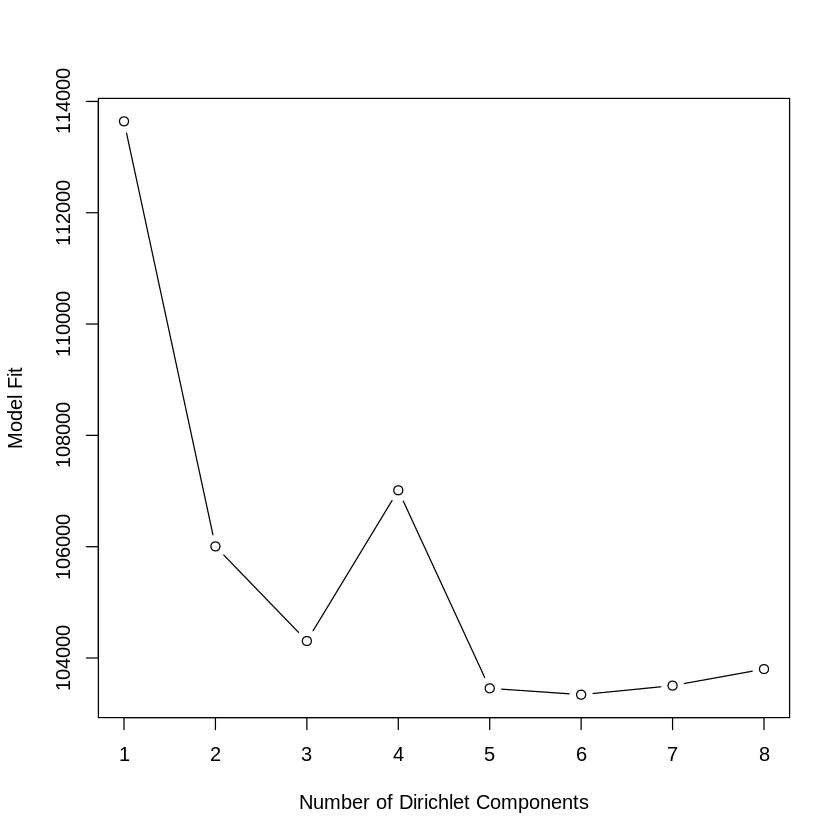

In [35]:
lplc <- sapply(fit, laplace) # AIC / BIC / Laplace
aic  <- sapply(fit, AIC) # AIC / BIC / Laplace
bic  <- sapply(fit, BIC) # AIC / BIC / Laplace
plot(lplc, type="b", xlab="Number of Dirichlet Components", ylab="Model Fit")

In [36]:
#identify the number of clusters that best fits the model

In [37]:
best <- fit[[which.min(lplc)]]
best <-fit[[3]]
best

class: DMN 
k: 3 
samples x taxa: 141 x 90 
Laplace: 104305.2 BIC: 104203.3 AIC: 103802.2 

In [38]:
#save.image(file = "go_terms_dmm.rdata")

#make a heatmap visualization of the cluster

log 2 Heatmap

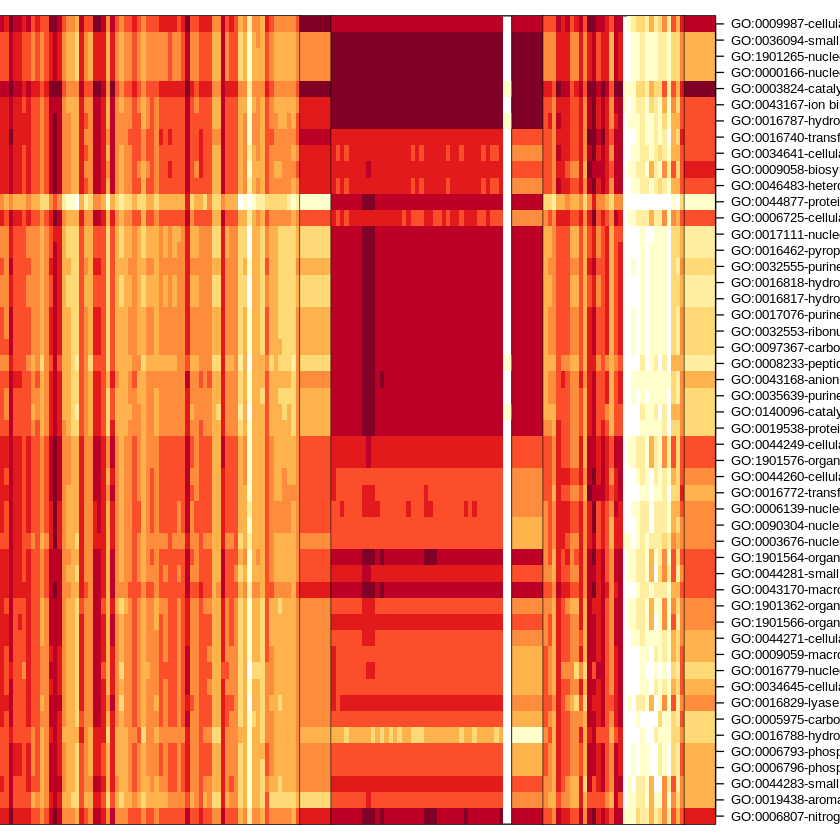

In [39]:
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =log2, lblwidth = 0.2 * nrow(count))

square root version

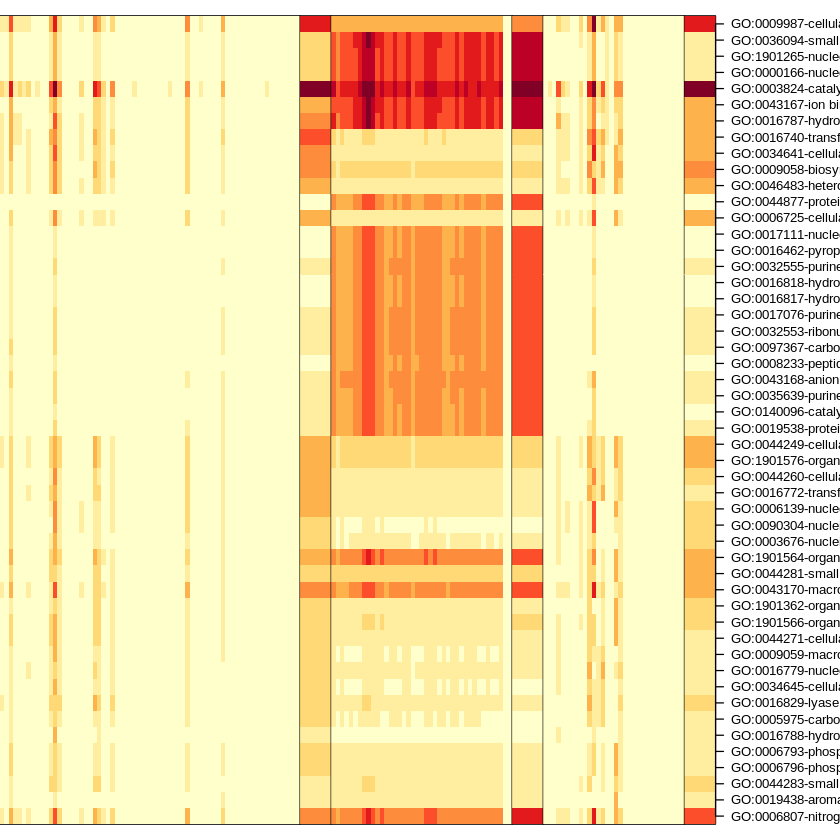

In [40]:
heatmapdmn(count, fit[[1]], best,ntaxa = 50,
           transform =sqrt, lblwidth = 0.2 * nrow(count))

print out the theta values

In [41]:
mixturewt(best)

pi,theta
<dbl>,<dbl>
0.4823277,708.70467
0.2906241,10503.53447
0.2270482,79.21304


save the datasheet that show which GO terms contributed to each dmm group

In [42]:
write.table(fitted(best),"GO_TERMS_DMM_contributions.tsv", sep="\t")

save a datasheet that identifies which sample belongs to which dmm group

In [43]:
ass <- apply(mixture(best), 1, which.max)
write.table(ass,"GO_TERMS_DMM_groups.tsv",sep="")

In [44]:
#add the dmm group to the metadata
sample_data(bac_pseq_prune)$dmn<-ass
bac_pseq_prune_comp<-microbiome::transform(bac_pseq_prune,"compositional")
#melt the phyloseq object into tidy form
tmp<-psmelt(bac_pseq_prune_comp)
tmp<-as_tibble(tmp)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 861 rows containing non-finite values (stat_bin).”


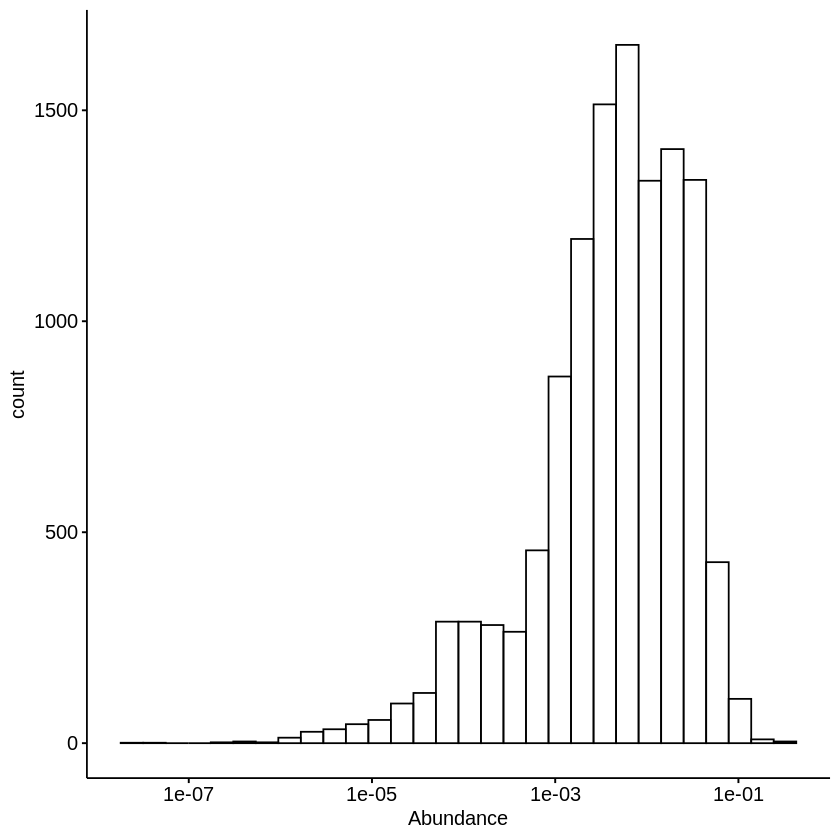

In [45]:
gghistogram(tmp,x = "Abundance",y = "..count..")+scale_x_log10() #move each dmm group into a colum of its own

In [46]:
#tmp$log2Abundance<-log2(tmp$Abundance)

In [47]:
#subset the dataset to only include the case, Go_term, count, and dmm group.
#obtain the avergage count for each Go term
#order the go terms from hight to lowest count

I added these filtering commands to pull out the counts with less than 1% relabund or greater tahn 22% (ie:molecular function)

In [48]:
d2<-tmp %>%
  select(case,OTU,Abundance, dmn)%>%
  group_by(OTU,case, dmn) %>%
  summarise(avg = mean(Abundance)) %>%
  arrange(desc(avg))

`summarise()` regrouping output by 'OTU', 'case' (override with `.groups` argument)



In [49]:
#d2$avg<-sqrt(d2$avg)

In [50]:
d3<-tidyr::spread(d2,dmn, avg)

In [51]:
#get the total count of the go terms and oder from greates to lowest

In [52]:
d3<-tidyr::spread(d2,dmn,avg)
d3$tot<-rowSums(d3[3:5], na.rm = T)
d3<-d3%>%arrange(desc(tot))
d3$tot<-NULL
head(d3)

OTU,case,1,2,3
<chr>,<chr>,<dbl>,<dbl>,<dbl>
GO:0003824-catalytic activity,COVID19,0.109352879,0.29285714,0.097175968
GO:0016787-hydrolase activity,COVID19,0.028312042,0.29285714,0.028805605
GO:0003824-catalytic activity,Control_Sick,0.108973363,0.06954130,0.113480076
GO:0003824-catalytic activity,Control_Healthy,0.107499082,0.06891539,0.096723461
"GO:0140096-catalytic activity, acting on a protein",COVID19,0.004725500,0.20714286,0.005114505
GO:0008233-peptidase activity,COVID19,0.003253628,0.20714286,0.004649460


In [53]:
d3<-d3%>%gather(data = d3,avg,3:5)
colnames(d3)<-c("name","case", "dmn","avg")

make the balloon plot

In [54]:
d4<-d3%>%filter(avg>0.01)%>%arrange(name,case,dmn)
d4<-d4[1:108,]

In [93]:
my_pal<-viridis(n = 256, alpha = 1, begin = 0, end = 1, direction = 1)

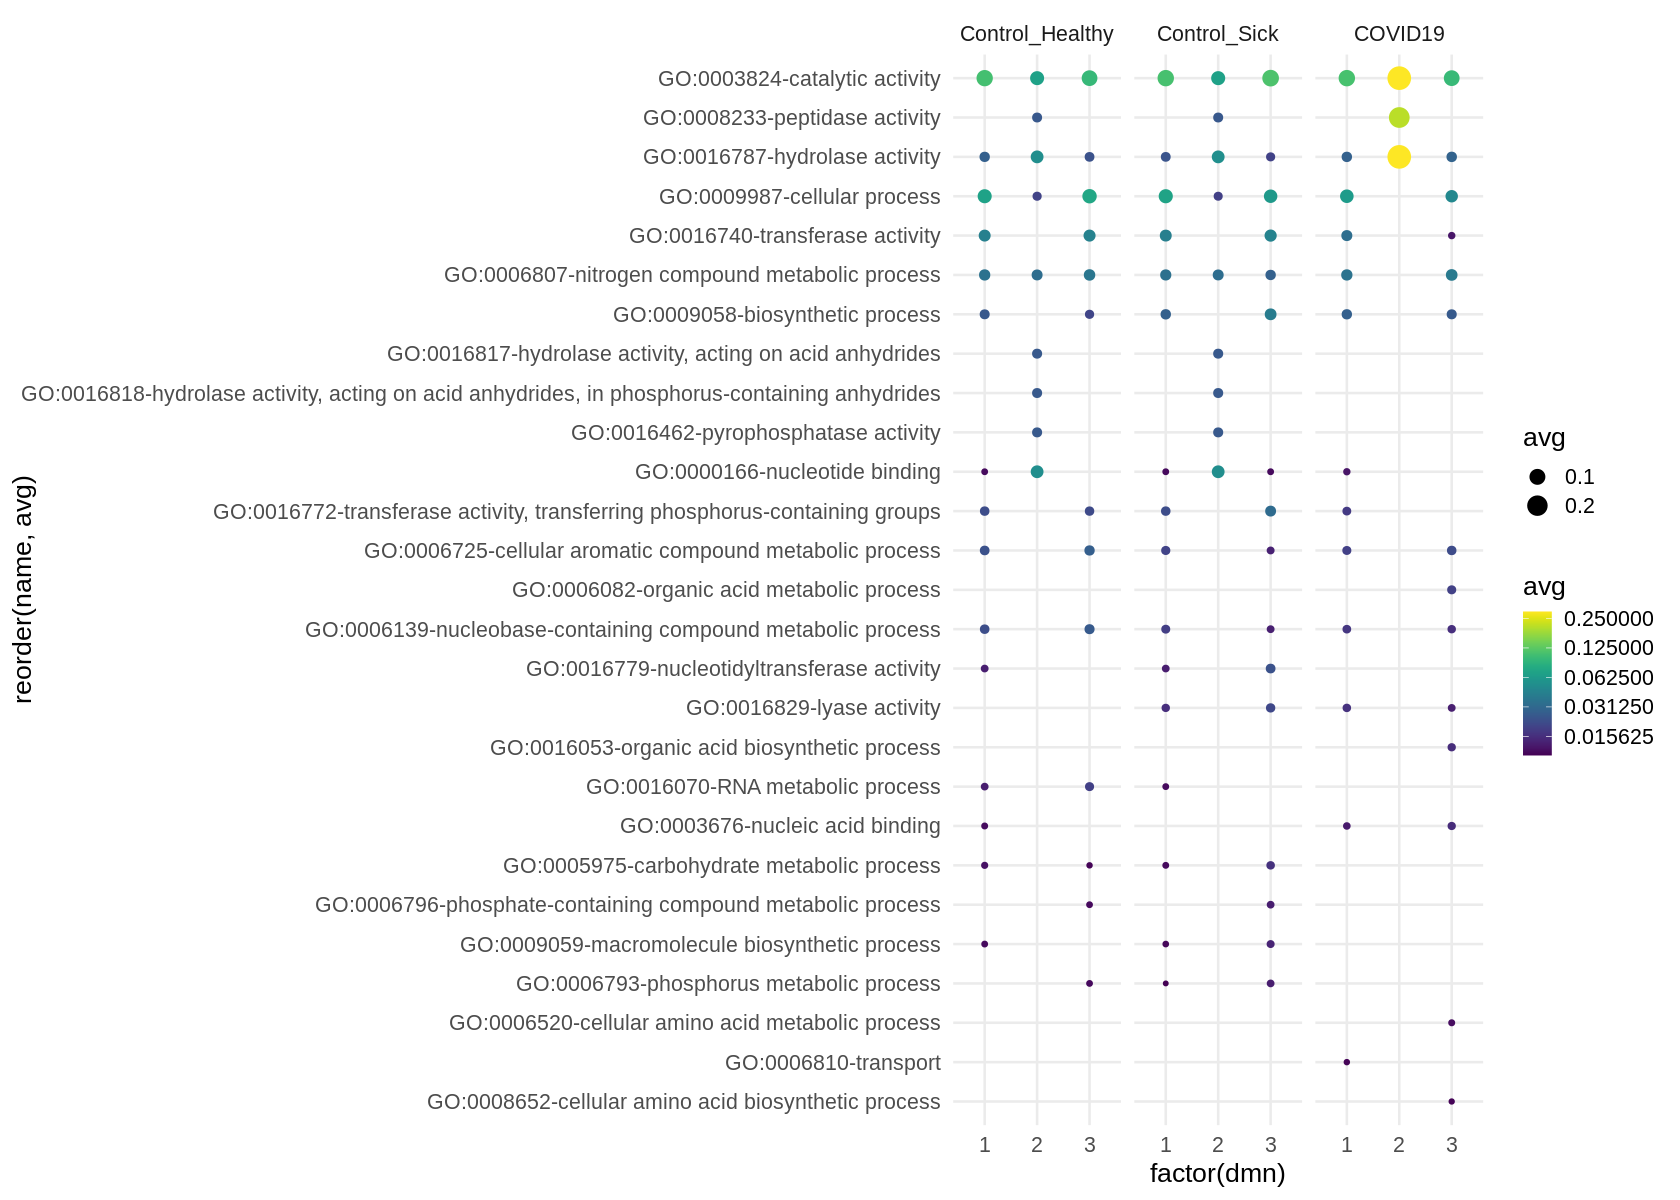

In [116]:
options(repr.plot.width=14, repr.plot.height=10)
a<-ggplot(data = d4,mapping = aes(x = factor(dmn),y =reorder(name,avg),size=avg,color=avg))+
geom_point()+
#theme(text=element_text(size=20))+
scale_colour_gradientn(colours = my_pal,trans="log2")+
facet_grid(facets = ~ case)+
theme_minimal(base_size = 16)

a


In [ ]:
#    ggballoonplot(d4, y ="name",x = "dmn", size = "avg", facet.by = "case",fill = "avg",ggtheme = theme_minimal())+
#      guides(size = FALSE)+
#    font("y.text", size = 12)+scale_fill_viridis_c()